In [140]:
#Import libraries
import pandas as pd
import numpy as np
import mysql.connector as mysql
import json

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, acf

from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler

# 1. Getting the Data

In [4]:
#Connect to the DB
with open('credentials.json') as file:
    credentials = json.load(file)
    
conn = mysql.connect(
    host=credentials['host'],
    user=credentials['user'],
    password=credentials['password']
)

In [5]:
#Query stocks prices from table
stock_query = '''
select 
    Date,
    Ticker,
    Open,
    High,
    Low,
    Close,
    AdjClose,
    Volume
from stocks.daily_stock_prices;
'''

stocks_df = pd.read_sql(stock_query, conn)

/home/edilson/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
#Splitting up the data by stock
stocks_dict = {
    ticker: stocks_df[stocks_df['Ticker'] == ticker].drop(columns = 'Ticker') 
    for ticker in stocks_df['Ticker'].unique()
}

# 2. Initial Exploration

In [54]:
#Setting up graph configurations
color_map = {
    'Open': '#404c85',
    'High': '#36822c',
    'Low': '#81d975',
    'Close': '#d15845',
    'AdjClose': '#eb7b6a',
    'Volume': '#919191'
}

In [89]:
#Define plot functions
def plot_stocks(data, ticker, highlight_series=None):
    '''
    Plot two graphs for the selected stock:
    1. Stock prices (Open, High, Low, Close and AdjClose)
    2. Volume of stocks traded
    '''
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2, 
        figsize=(16,6),
        gridspec_kw={'width_ratios': [1.5,1]}
    )
    
    #Plot stock prices
    stock_price_cols = ['Open', 'High', 'Low', 'Close', 'AdjClose']
    for col in stock_price_cols:
        if highlight_series != None:
            opacity = 1 if col in highlight_series else 0.1
        else:    
            opacity = 1
        
        ax1.plot(
            data[ticker]['Date'], data[ticker][col],
            label=col,
            color=color_map[col],
            alpha=opacity
        )
   
    #Plot volume of stocks traded
    ax2.plot(
        data[ticker]['Date'], data[ticker]['Volume'],
        label='Volume',
        color=color_map['Volume']
    )
    
    for side in ['top', 'right', ]:
        ax1.spines[side].set_visible(False)
        ax2.spines[side].set_visible(False)
        
    ax1.set_title('Stock Prices')
    ax2.set_title('Trade Volume')
    fig.suptitle(ticker)
    
    fig.legend(frameon=False, fontsize = 13, loc=7)
    
    plt.show()

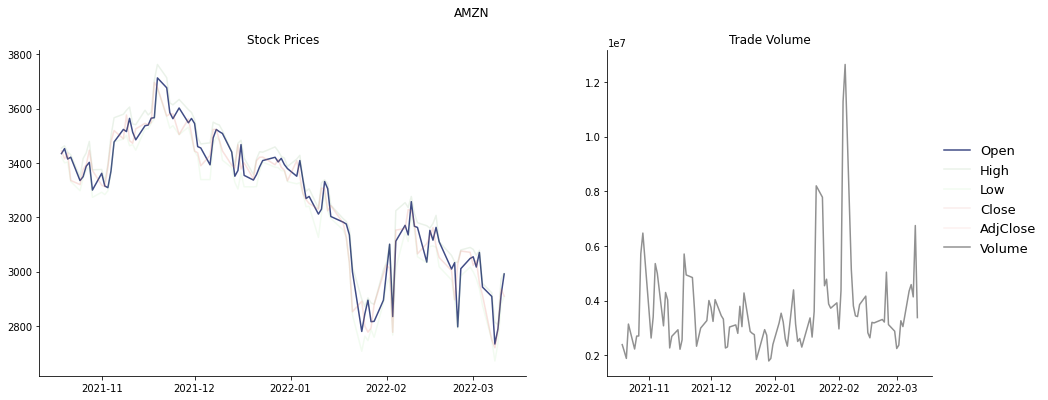

In [90]:
#Plot AMZN
plot_stocks(stocks_dict, 'AMZN', ['Open'])

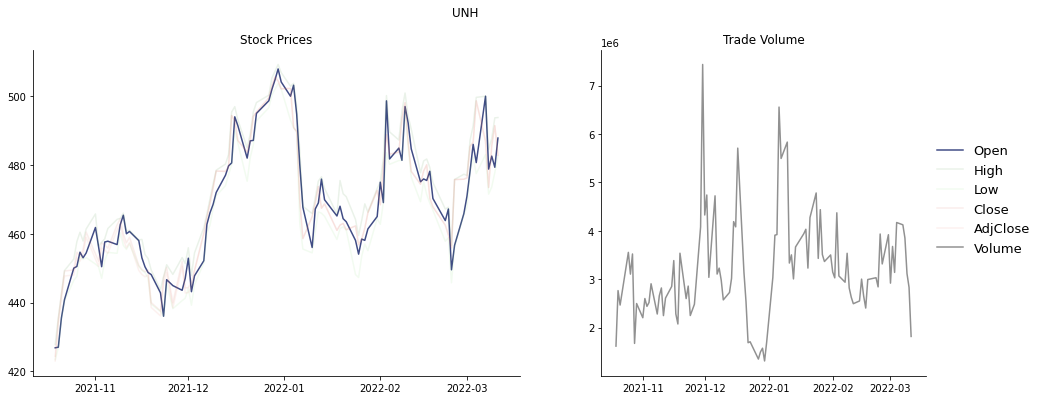

In [91]:
#Plot UNH
plot_stocks(stocks_dict, 'UNH', ['Open'])

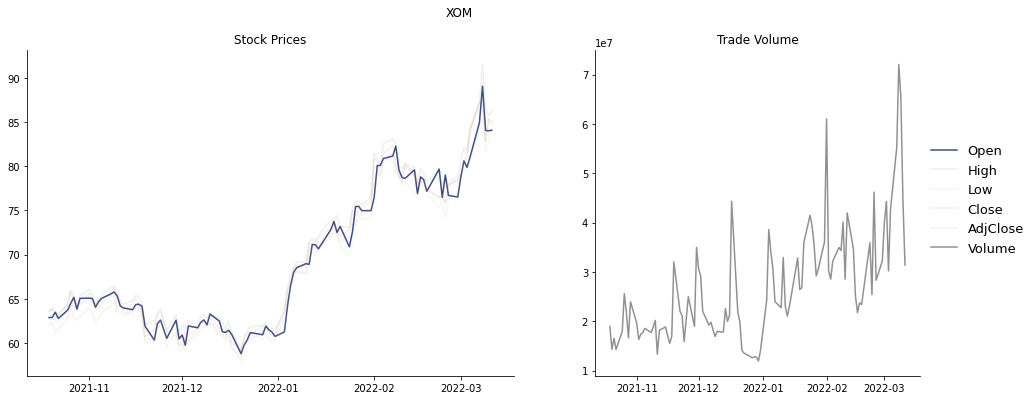

In [92]:
#Plot XOM
plot_stocks(stocks_dict, 'XOM', ['Open'])

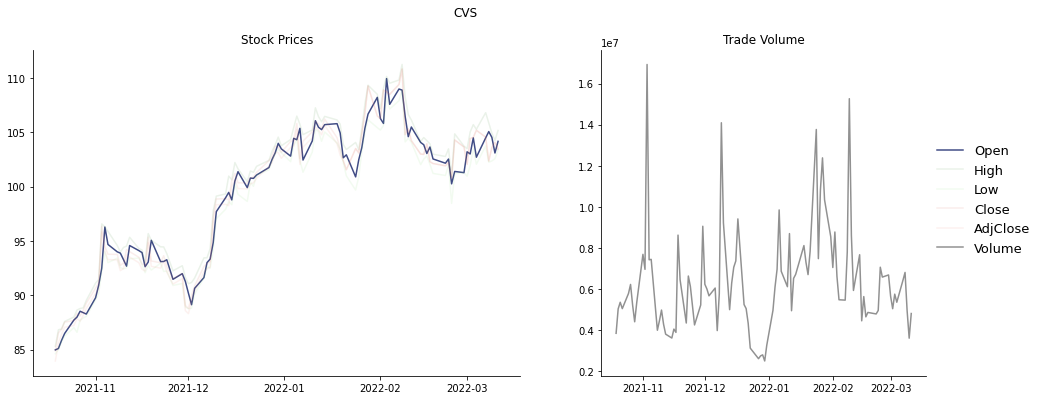

In [93]:
#Plot CVS
plot_stocks(stocks_dict, 'CVS', ['Open'])

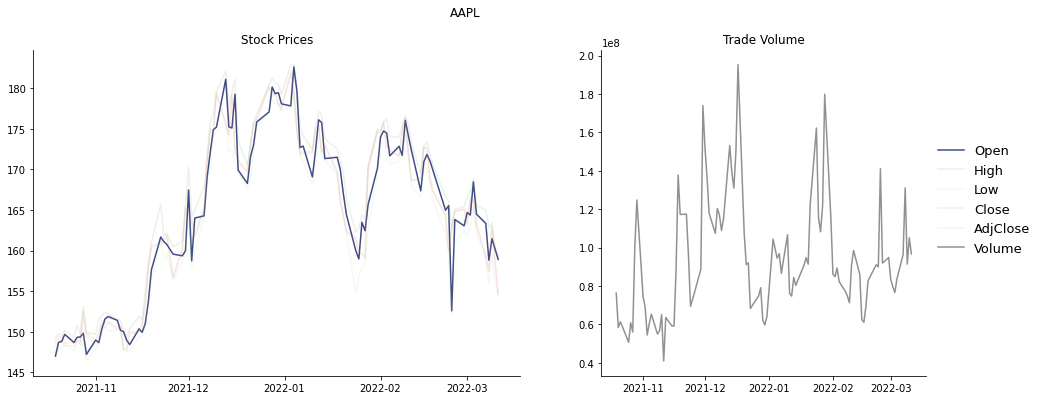

In [94]:
#Plot AAPL
plot_stocks(stocks_dict, 'AAPL', ['Open'])

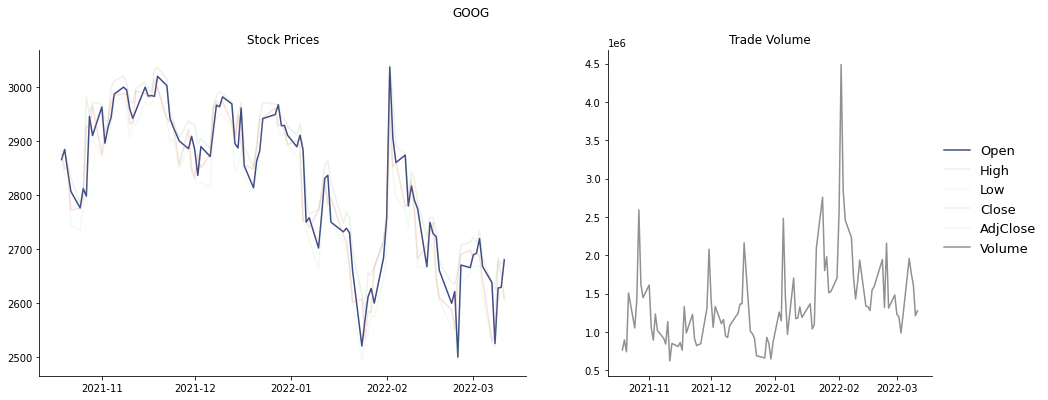

In [95]:
#Plot GOOG
plot_stocks(stocks_dict, 'GOOG', ['Open'])

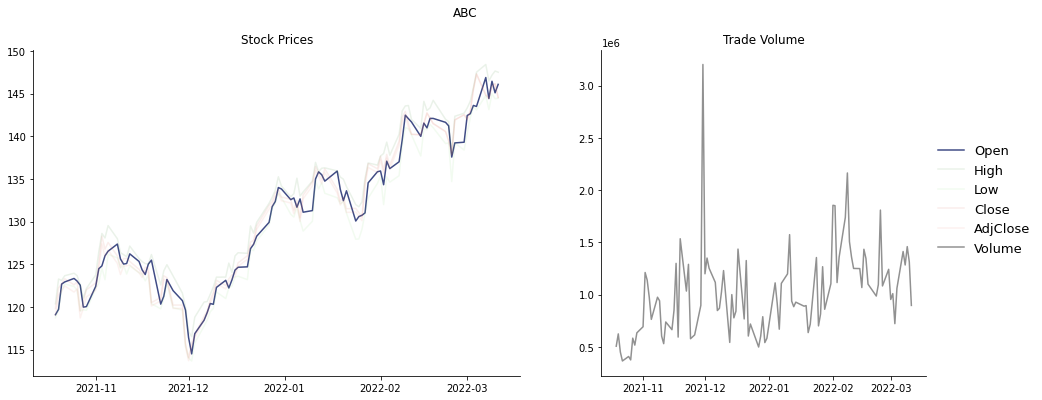

In [96]:
#Plot ABC
plot_stocks(stocks_dict, 'ABC', ['Open'])

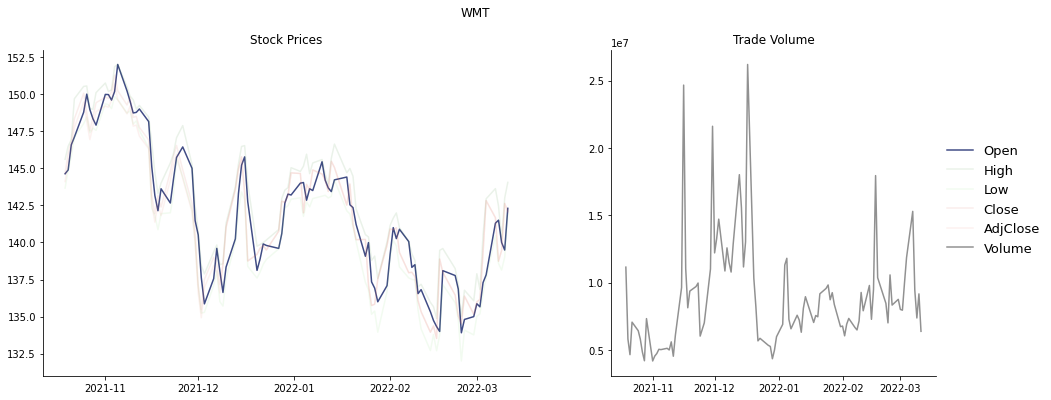

In [97]:
#Plot WMT
plot_stocks(stocks_dict, 'WMT', ['Open'])

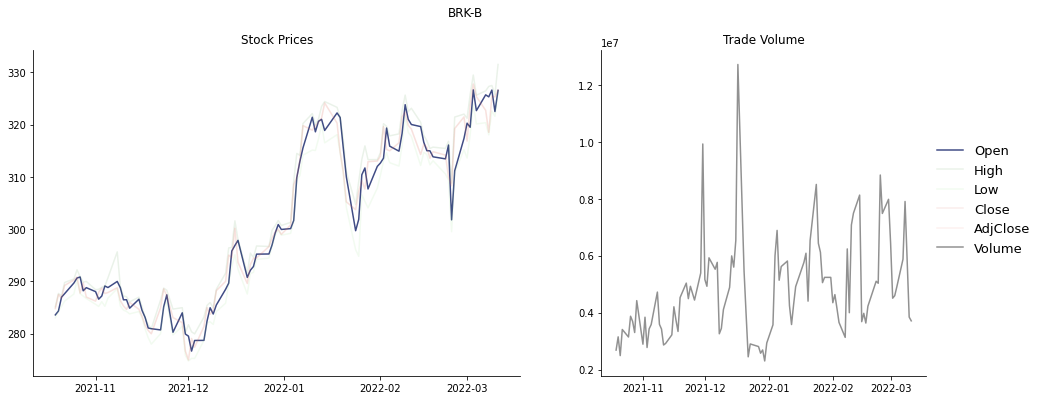

In [98]:
#Plot BRK-B
plot_stocks(stocks_dict, 'BRK-B', ['Open'])

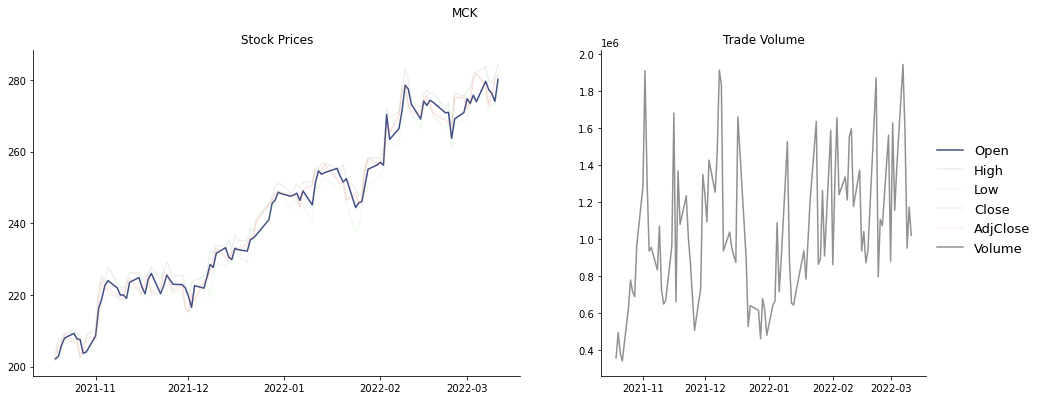

In [99]:
#Plot MCK
plot_stocks(stocks_dict, 'MCK', ['Open'])

On the graphs above, we highlighted the daily opening stock prices and the trade volume. For each stock, some trend can be seen for both variables. However, there is not much more we can take from those plots.

The next step is to understand how we are going to predict stock prices for the following days. As in the plots, we are going to focus on the "Open" value. For this analysis, no additional information we'll be used, such news or socia media data. As such, there are 3 points we can further explore:

* How the current value relates to data from previous dates;
* How the other fields correlate to the "Open" stock price;
* How the "Volume" field correlates do "Open".

# 3. Understanding Relationships

## 3.1. "Open" Autocorrelation

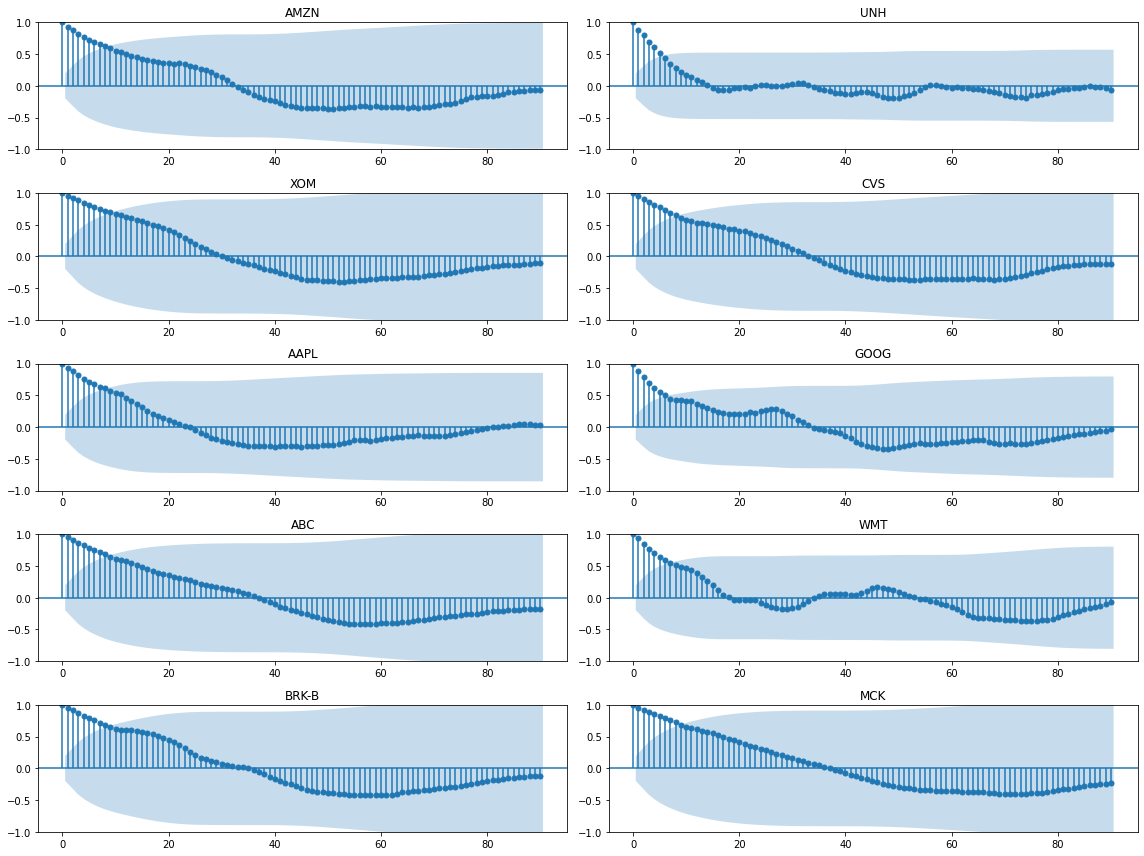

In [108]:
#Plot the autocorrelation for 80 lags
fig, ax = plt.subplots(5, 2, figsize=(16,12))

for i, ticker in enumerate(stocks_dict.keys()):
    row, col = divmod(i, 2)
    
    plot_acf(
        x=stocks_dict[ticker]['Open'].values, 
        lags=90,
        title=ticker,
        alpha=0.05,
        ax=ax[row, col]
    )

fig.tight_layout()
plt.show()

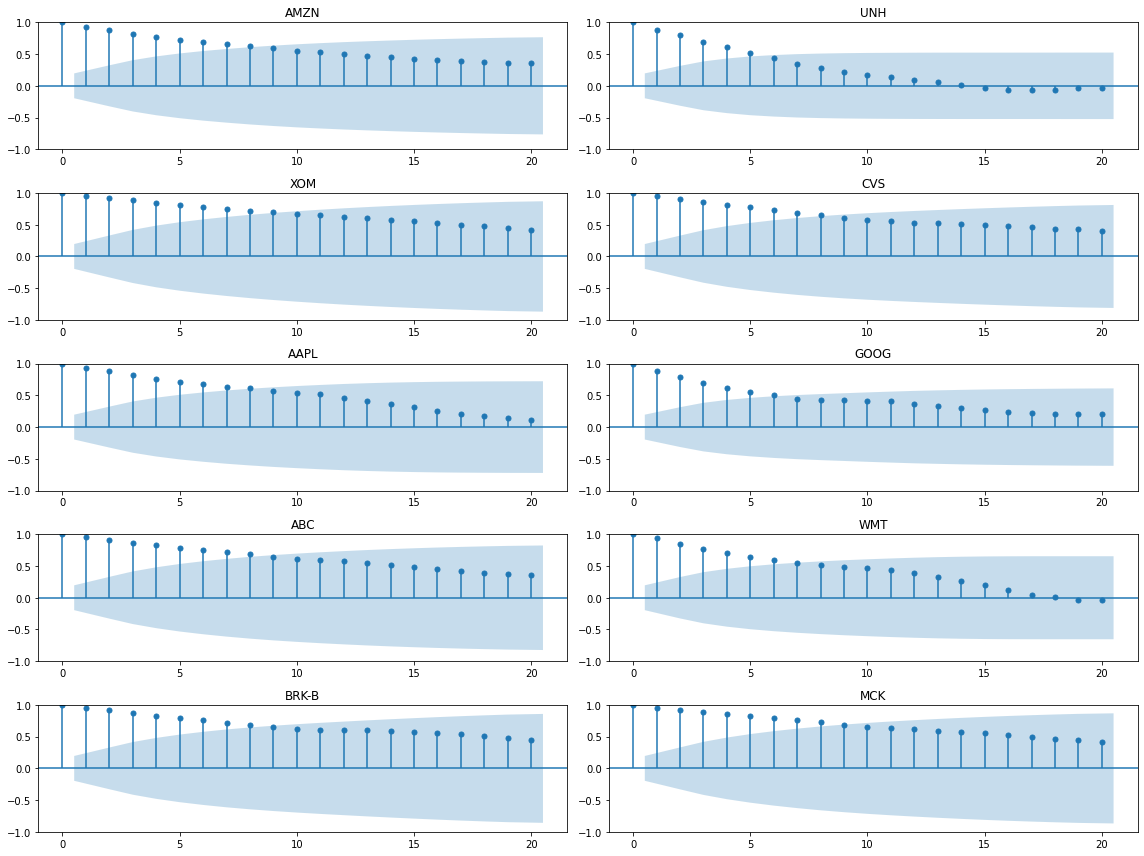

In [106]:
#Plot the autocorrelation for 20 lags
fig, ax = plt.subplots(5, 2, figsize=(16,12))

for i, ticker in enumerate(stocks_dict.keys()):
    row, col = divmod(i, 2)
    
    plot_acf(
        x=stocks_dict[ticker]['Open'].values, 
        lags=20,
        title=ticker,
        alpha=0.05,
        ax=ax[row, col]
    )

fig.tight_layout()
plt.show()

We plotted the autocorrelation for two lag ranges, 90 and 20. The first one is intended to gives us a broader sense of how the current stock prices have little to do with how they performed 1 or 2 months before. As for the second set of graphs, the idea is to focus on the very short-term, where we can find some relevant correlations. Another thing we can observe as how each stock behaves in a slightly different way. 

This gives us an indication some adjustment should be made when predicting each stock price. This information will be useful for us later on.

## 3.2. Relationship Between Stock Prices

In [39]:
#Define function for plotting correlations heatmap
def plot_correlations_map(data, ticker):
    '''
    Plot correlation coefficients heatmap for the
    Open, Close, High, Low and AdjClose stock prices
    '''
    
    price_cols = ['Open', 'Close', 'High', 'Low', 'AdjClose']
    graph_data = data[ticker][price_cols].corr()
    
    fig, ax = plt.subplots(figsize = (5,5))
    image = ax.imshow(graph_data, cmap='Blues')
    
    ax.set_xticks(range(len(price_cols)), labels = price_cols)
    ax.set_yticks(range(len(price_cols)), labels = price_cols)
    
    for i in range(len(price_cols)):
        for j in range(len(price_cols)):
            ax.text(
                j, i, '{:.2f}'.format(graph_data.values[i, j]),
                ha='center',
                va='center',
                color='black'
            )
    
    ax.set_title(ticker)
    fig.tight_layout()
    plt.show()

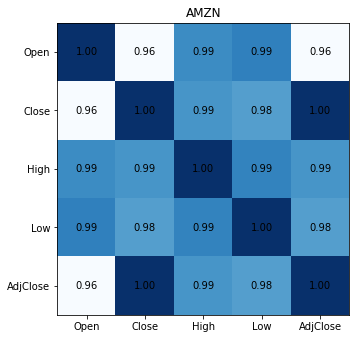

In [41]:
#AMZN
plot_correlations_map(stocks_dict, 'AMZN')

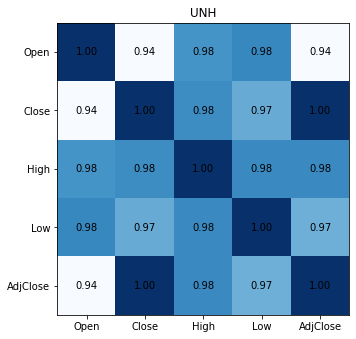

In [42]:
#UNH
plot_correlations_map(stocks_dict, 'UNH')

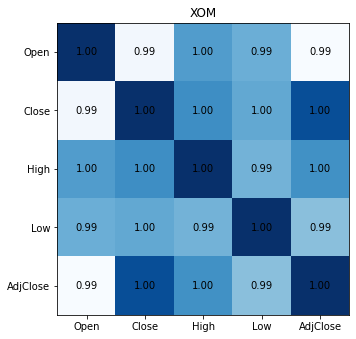

In [43]:
#XOM
plot_correlations_map(stocks_dict, 'XOM')

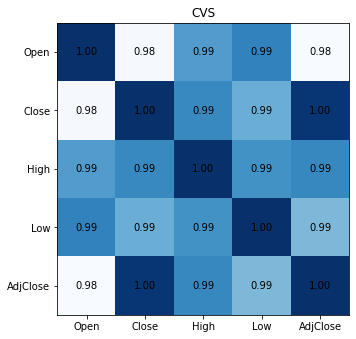

In [44]:
#CVS
plot_correlations_map(stocks_dict, 'CVS')

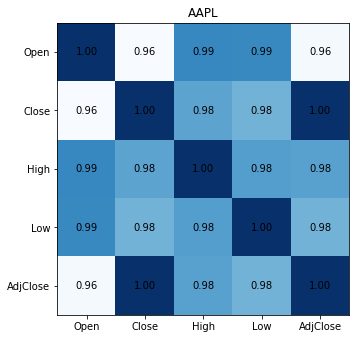

In [45]:
#AAPL
plot_correlations_map(stocks_dict, 'AAPL')

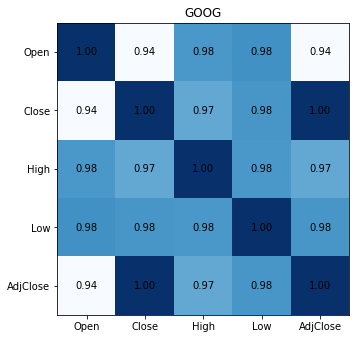

In [46]:
#GOOG
plot_correlations_map(stocks_dict, 'GOOG')

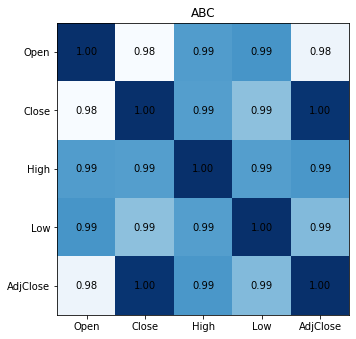

In [47]:
#ABC
plot_correlations_map(stocks_dict, 'ABC')

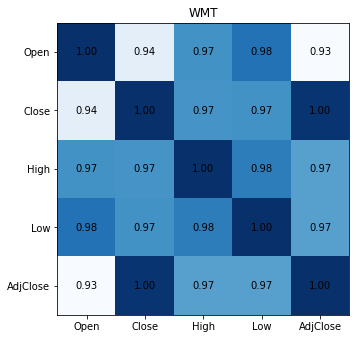

In [48]:
#WMT
plot_correlations_map(stocks_dict, 'WMT')

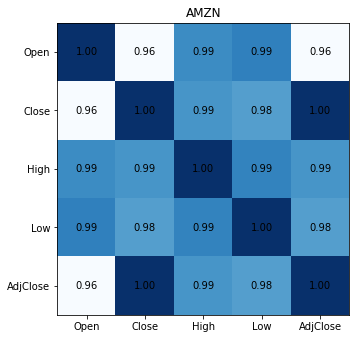

In [49]:
#BRK-B
plot_correlations_map(stocks_dict, 'AMZN')

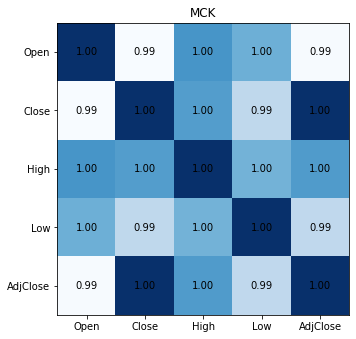

In [50]:
#MCK
plot_correlations_map(stocks_dict, 'MCK')

The heatmaps above highlight what we expected for the relationships between the different stock prices. As such, it would not make much sense to include these variables in the prediction, even applying some lagging.

## 3.3. "Open" vs. "Volume"

In [145]:
scaler = StandardScaler()
scaler.fit_transform(stocks_dict['AMZN']['Open'].values.reshape(-1,1)).flatten()

array([ 0.69021116,  0.76770564,  0.60567098,  0.63414629,  0.27134982,
        0.33256122,  0.49493369,  0.55441585,  0.12378455,  0.38440753,
        0.18702078,  0.16166717,  0.41899955,  0.87038585,  1.06545218,
        1.0317459 ,  1.23685296,  1.02225414,  0.90413436,  1.12349966,
        1.13193679,  1.24043812,  1.24731491,  1.86465884,  1.71148256,
        1.32615962,  1.23178986,  1.39812856,  1.16838473,  1.2352916 ,
        1.15724817,  0.79867027,  0.77757745,  0.51602651,  0.9336643 ,
        1.064482  ,  1.03069126,  1.002596  ,  0.714299  ,  0.33884684,
        0.42726777,  0.82976157,  0.35238826,  0.27978695,  0.36420045,
        0.48396501,  0.58166761,  0.63304942,  0.5609538 ,  0.61642853,
        0.52024507,  0.45747334,  0.33884684,  0.58251111,  0.28257083,
       -0.00703315,  0.02574517, -0.24875704, -0.17159935,  0.25658485,
        0.14483514, -0.28550057, -0.37366813, -0.40260794, -0.57101266,
       -1.14608754, -2.06995296, -1.7963787 , -1.58481815, -1.91

In [146]:
#Define function to plot distribution of "Open" vs. "Volume"
def plot_distribution(data, ticker, ax, norm=False, first_field='Open', second_field='Volume'):
    ax = ax or plt.gca()
    
    graph_data = data[ticker]
    x_data = graph_data[first_field]
    y_data = graph_data[second_field]
    
    if norm:
        scaler = StandardScaler()
        x_data = scaler.fit_transform(x_data.values.reshape(-1,1))
        y_data = scaler.fit_transform(y_data.values.reshape(-1,1))
    
    for side in ['top', 'right']:
        ax.spines[side].set_visible(False)
    
    _, _, r_val, _, _ = linregress(x_data.flatten(), y_data.flatten())
    ax.set_title('{0} (R2 = {1:.2f})'.format(ticker, r_val**2))
    
    return ax.scatter(x=x_data, y=y_data)

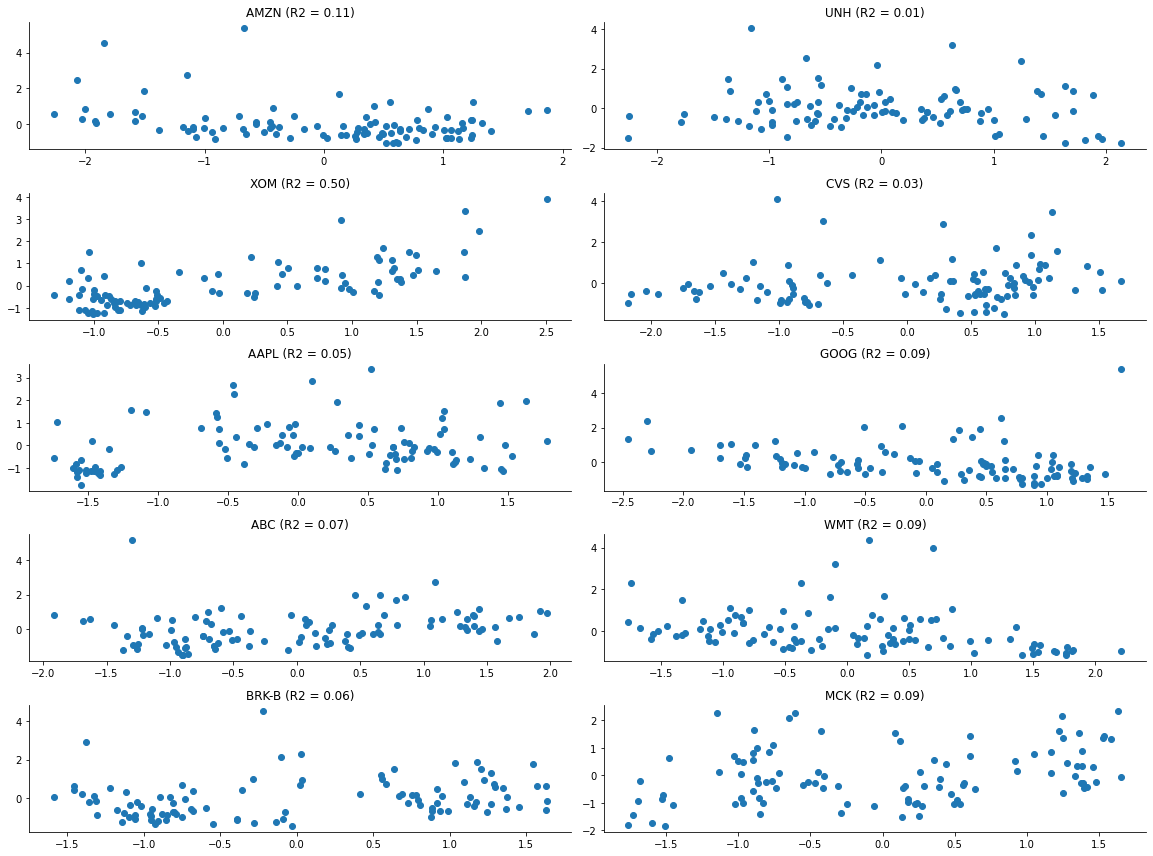

In [147]:
#Plot "Open" vs. "Volume" for the same date
fig, ax = plt.subplots(nrows=5, ncols=2, figsize = (16,12))

for i, ticker in enumerate(stocks_dict.keys()):
    row, col = divmod(i, 2
                     )
    plot_distribution(stocks_dict, ticker, ax[row, col], norm=True)
    
plt.tight_layout()
#plt.gcf().set_dpi(1000)
plt.show()

Even though the distributions sometimes indicates some linear relationships between the variables, the R2 values highlight this is not the case. The main exception here is the XOM stock, with R2 = 0.50.

Just to be clear, some scaling was done in the data, given the different sizes for the values of both fields. 

However, this correlation, in itself, would not be very useful in our prediction, given we could never now the amount of stocks being traded upfront. We can, however, try to understand how the "Open" stock value is explained by the amount of trades in the previous days.

In [ ]:
#Define function to compute correlation of "Open" against lagged "Volume" values
